In [65]:
import os
import cv2
import numpy as np
import random

from tqdm import tqdm
from utils import (
    overlay_image_with_blend, 
    gaussian_kernel, zip_folder)

from utils.algorithms import (
    perlin_noise, 
    generate_parallel_or_perpendicular_lines,
    generate_parallel_lines_adjacent)

import matplotlib.pyplot as plt

In [66]:
def entre(min_val, max_val, integer=False):
    """ Generate a random value between [min_val, max_val] """
    if integer:
        return random.randint(min_val, max_val)
    return random.uniform(min_val, max_val)

def generate_images(shape_image_base=(512, 512), gsd=0.25, num_lines_range=(10, 16), p=0.5):
    
    input, input_line = np.zeros(shape_image_base), np.zeros(shape_image_base)
    output_pretil, output_line = np.zeros(shape_image_base), np.zeros(shape_image_base)   
    img_tmp = np.zeros(shape_image_base)

    num_lines = np.random.randint(num_lines_range[0], num_lines_range[1] + 1)
    num_no_pretil = np.random.randint(1, num_lines_range[0] - 2)
    num_rand = np.random.rand()
    count = 0

    # Generar las lineas de los pretiles
    if  num_rand < p: #Pretiles normales
        lines, lens = generate_parallel_or_perpendicular_lines(shape_image_base, num_lines)
    else: #Pretiles en zanjas
        lines,lens  = generate_parallel_lines_adjacent(shape_image_base, gsd)

    for idx, (line, lenght) in enumerate(zip(lines,lens)):
            
        pretril_size_low = np.round(1 / gsd)
        pretil_size_high = np.round(4 / gsd)
        random_size = entre(pretril_size_low, pretil_size_high, integer=True)
        
        if (lenght*gsd) < 5: # NO Pretil menor a x [m] de largo (deben estar en la imagen de input)
            for point in line:
                factor = entre(0.5, 1)
                gaussian_size = int(random_size * factor)

                if num_rand < p: # Dimensiones pretil normal
                    gaussian = gaussian_kernel(gaussian_size, normalize=True)

                else: # Dimensiones pretil zanja
                    if idx == 1: # Zanja
                        pretril_size_low = np.round(3 / gsd)
                        pretil_size_high = np.round(4.1 / gsd)
                        random_size = entre(pretril_size_low, pretil_size_high, integer=True)
                        gaussian_size = int(random_size * factor)
                        gaussian = gaussian_kernel(gaussian_size, normalize=True) * -1
                    else: # Pretil lateral zanja
                        pretril_size_low = np.round(0.9 / gsd)
                        pretil_size_high = np.round(1.2 / gsd)
                        random_size = entre(pretril_size_low, pretil_size_high, integer=True)
                        gaussian_size = int(random_size * factor)
                        gaussian = gaussian_kernel(entre(9,12, integer=True), normalize=True)

                input_line += overlay_image_with_blend(img_tmp, gaussian, position=point)

        if count < num_no_pretil: # Pretiles con dimesiones ancho fuera de lo normal
            count +=1 
            for point in line:
                if num_rand < 0.5: # Por debajo de la norma
                    pretril_size_low = np.round(0.4 / gsd)
                    pretil_size_high = np.round(1 / gsd)
                    random_size = entre(pretril_size_low, pretil_size_high, integer=True)
                else: # Por encima de la norma
                    pretril_size_low = np.round(4 / gsd)
                    pretil_size_high = np.round(6 / gsd)
                    random_size = entre(pretril_size_low, pretil_size_high, integer=True)
        
                factor = entre(0.5, 1)
                gaussian_size = int(random_size * factor)
                gaussian = gaussian_kernel(gaussian_size, normalize=True)
                input_line += overlay_image_with_blend(img_tmp, gaussian, position=point)

        else: # Pretiles 
            for point in line:
                factor = entre(0.5, 1)
                gaussian_size = int(random_size * factor)

                if num_rand < p: # Dimensiones pretil normal ancho
                    gaussian = gaussian_kernel(gaussian_size, normalize=True)

                else: # Dimensiones pretil zanja ancho
                    if idx == 1: # Zanja
                        pretril_size_low = np.round(3 / gsd)
                        pretil_size_high = np.round(4.1 / gsd)
                        random_size = entre(pretril_size_low, pretil_size_high, integer=True)
                        gaussian_size = int(random_size * factor)
                        gaussian = gaussian_kernel(gaussian_size, normalize=True) * -1
                    else: # Pretil lateral zanja
                        pretril_size_low = np.round(0.9 / gsd)
                        pretil_size_high = np.round(1.2 / gsd)
                        random_size = entre(pretril_size_low, pretil_size_high, integer=True)
                        gaussian_size = int(random_size * factor)
                        gaussian = gaussian_kernel(entre(9,12, integer=True), normalize=True)

                input_line += overlay_image_with_blend(img_tmp, gaussian, position=point)
                output_line += overlay_image_with_blend(img_tmp, gaussian, position=point)
        
    if num_rand < p: # Dimensiones pretil normal altura
        input_line = input_line / np.max(input_line) * entre(0.5, 2.5)
        input = np.maximum(input, input_line)
        output_line = output_line / np.max(output_line) * entre(0.5, 2.5)
        output_pretil = np.maximum(output_pretil, output_line)
            
    else: # Dimensiones pretil zanja altura
        if idx == 1:
            input_line = input_line / np.min(input_line) * -entre(1, 2)
            input  += input_line
            output_line = output_line / np.min(output_line) * -entre(1, 2)
            output_pretil += output_line
        else:
            input_line = input_line / np.max(input_line) * entre(0.5, 2.5)
            input += input_line 
            output_line = output_line / np.max(output_line) * entre(0.5, 2.5)
            output_pretil += output_line

    img_pretil_binary = np.where(output_pretil >= 0.1, 1, 0)
    img_zanja = np.where(output_pretil <= -0.1, 1, 0)
    img_background = 1 - img_pretil_binary - img_zanja
    
    output_pretil = np.clip(output_pretil, -10, 10)
    output_class = np.stack((img_background, img_pretil_binary, img_zanja), axis=-1) * 255

    noise = perlin_noise((512, 512, 1), octaves=(entre(0.01, 0.02), entre(0.02, 0.04), entre(0.04, 0.08), entre(0.08, 0.1), entre(0.1, 0.2), entre(0.2, 0.3), entre(0.3, 1)))
    # input += noise
    input = np.clip(input, -10, 10)

    return input, output_class, output_pretil


        # for point in line:
        #     factor = entre(0.5, 1)
        #     gaussian_size = int(random_size * factor)

        #     if num_rand < p: # Generar pretil
        #         gaussian = gaussian_kernel(gaussian_size, normalize=True)

        #     else: # Generar zanja
        #         if idx == 1:
        #             pretril_size_low = np.round(3 / gsd)
        #             pretil_size_high = np.round(4.1 / gsd)
        #             random_size = entre(pretril_size_low, pretil_size_high, integer=True)
        #             gaussian_size = int(random_size * factor)
        #             gaussian = gaussian_kernel(gaussian_size, normalize=True) * -1
        #         else:
        #             pretril_size_low = np.round(0.9 / gsd)
        #             pretil_size_high = np.round(1.2 / gsd)
        #             random_size = entre(pretril_size_low, pretil_size_high, integer=True)
        #             gaussian_size = int(random_size * factor)
        #             gaussian = gaussian_kernel(entre(9,12, integer=True), normalize=True)

    #         img_line += overlay_image_with_blend(img_tmp, gaussian, position=point)
        
    #     if num_rand < p:
    #         img_line = img_line / np.max(img_line) * entre(0.5, 2.5)
    #         img = np.maximum(img, img_line)
    #     else:
    #         if idx == 1:
    #             img_line = img_line / np.min(img_line) * -entre(1, 2)
    #             img += img_line
    #         else:
    #             img_line = img_line / np.max(img_line) * entre(0.5, 2.5)
    #             img += img_line 
        
    # # Overlay the lines on the image
    # img_pretil = img.copy()
    # img_pretil_binary = np.where(img >= 0.1, 1, 0)
    # img_zanja = np.where(img <= -0.1, 1, 0)
    # img_background = 1 - img_pretil_binary - img_zanja
    # img_pretil = np.clip(img_pretil, -10, 10)

    # img_class = np.stack((img_background, img_pretil_binary, img_zanja), axis=-1)
    # noise = perlin_noise((512, 512, 1), octaves=(entre(0.01, 0.02), entre(0.02, 0.04), entre(0.04, 0.08), entre(0.08, 0.1), entre(0.1, 0.2), entre(0.2, 0.3), entre(0.3, 1)))
    # img += noise
    # img = np.clip(img, -10, 10)

    # return img, img_class, img_pretil

In [67]:
num_images = 100
dataset_path = 'dataset'

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

gsd = 0.25  # Ground Sampling Distance (m/px)
shape_image_base = (512, 512)

for idx in tqdm(range(num_images)):
    input, output_class, output_pretil = generate_images(shape_image_base, gsd, p=1)
    output_pretil = output_pretil.astype(np.half) 
    input = input.astype(np.half)

    np.savez_compressed(f'{dataset_path}/img_{idx}.npz', input)
    #img_class = cv2.cvtColor(img_class, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'{dataset_path}/img_class_{idx}.png', output_class)
    np.savez_compressed(f'{dataset_path}/img_pretil_{idx}.npz', output_pretil)

    # # Crear una figura con tres subplots
    # fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # # Mostrar la primera imagen
    # axs[0].imshow(img, cmap='grey')
    # axs[0].set_title('Image')
    # axs[0].axis('off')

    # # Mostrar la segunda imagen
    # axs[1].imshow(img_class)
    # axs[1].set_title('Image Class')
    # axs[1].axis('off')

    # # Mostrar la tercera imagen
    # axs[2].imshow(img_pretil, cmap='grey')
    # axs[2].set_title('Image Pretil')
    # axs[2].axis('off')

    # # Ajustar el espacio entre los subplots
    # plt.tight_layout()

    # # Agregar un título general a la figura
    # fig.suptitle('Dataset Artificial', fontsize=16, y=1.1)

    # # Mostrar la figura
    # plt.show()
        

100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


In [68]:
zip_folder(dataset_path, f'{dataset_path}.zip')

Zipping files: 100%|██████████| 300/300 [00:00<00:00, 1683.12file/s]


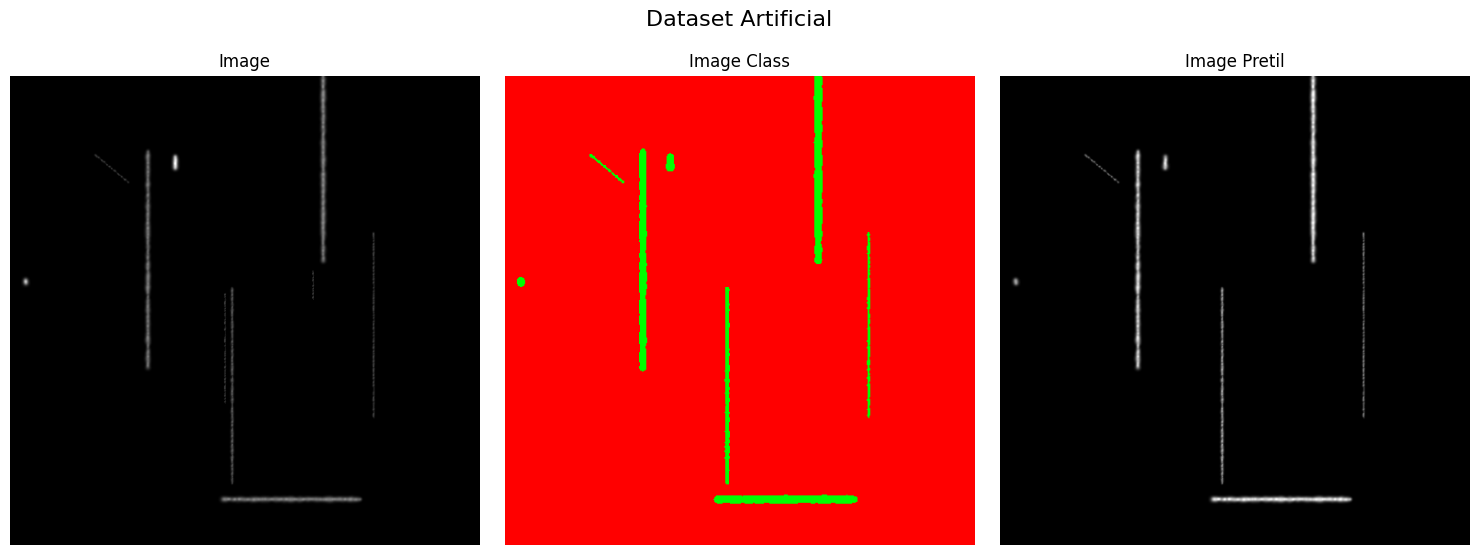

In [69]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar las imágenes
idx = 10
dataset_name = 'dataset'
img = np.load(f'{dataset_name}/img_{idx}.npz')['arr_0']
img_class = cv2.imread(f'{dataset_name}/img_class_{idx}.png')
img_pretil = np.load(f'{dataset_name}/img_pretil_{idx}.npz')['arr_0']

# Crear una figura con tres subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Mostrar la primera imagen
axs[0].imshow(img, cmap='grey')
axs[0].set_title('Image')
axs[0].axis('off')

# Mostrar la segunda imagen
axs[1].imshow(img_class)
axs[1].set_title('Image Class')
axs[1].axis('off')

# Mostrar la tercera imagen
axs[2].imshow(img_pretil, cmap='grey')
axs[2].set_title('Image Pretil')
axs[2].axis('off')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Agregar un título general a la figura
fig.suptitle('Dataset Artificial', fontsize=16, y=1.1)

# Mostrar la figura
plt.show()